In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook

import glob
import researchpy as rp
import re

**There are four assumptions that must be met before using two-way ANOVA:**

- Normality: Observations from the sample population are normally distributed.
- Sample Size: The number of observations must be the same for each group.
- Equal Variances: The variances for each group are equal.
- Independence: Observations in each group are independent.

In [83]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary

plate_type = 'DIV19'
# read the csv file into a pandas DataFrame, skipping the metadata at the top
# df = pd.read_csv(filename, skiprows=lines_to_skip, header=[i for i in range(header_lines)])
### read all data

firstTableHeading = "Mean Firing Rate (Hz)"
## conditions taken:
basal_folder = f"data/Div19_basal/"
bicu2uM_folder = f"data/Div19_2uMbicucilin/"
bicu6uM_folder = f"data/Div19_6uMbicucilin/"
bicu26uM_folder = f"data/Div19_26uMbicucilin/"

# basal_df= pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 basal(000)(000)_CompiledData(1).csv",
#                     skiprows = lines_to_skip)

# bicucilin_df = pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 bicu 6 microM(000)(000)_CompiledData.csv",
#                          skiprows = lines_to_skip)

# basal_df = basal_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# bicucilin_df = bicucilin_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# basal_df

In [99]:
def read_csvs_to_dict(folder):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            print(plate_key)
            df = pd.read_csv(file, skiprows = lines_to_skip)
            print(df)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict

In [126]:
# def rename_row_names(experiment_df):
#     replace_rows = experiment_df['Unnamed: 0'].isin(['B Replicates', np.nan]) 
#     replace_count = replace_rows.sum()
    
#     replicates = (f"B Replicate {i+1}" for i in range(replace_count))
#     with pd.option_context('mode.chained_assignment', None):
#         experiment_df.loc[replace_rows, 'Unnamed: 0'] = list(replicates)
#     return experiment_df

def rename_row_names(experiment_df):
    if 'Unnamed: 0' in experiment_df.columns:
        # 'Unnamed: 0' is a column
        replace_rows = experiment_df['Unnamed: 0'].isin(['B Replicates', np.nan])
        column_name = 'Unnamed: 0'
    elif experiment_df.index.name == 'Unnamed: 0':
        # 'Unnamed: 0' is the index name
        replace_rows = experiment_df.index.isin(['B Replicates', np.nan])
        column_name = experiment_df.index.name
    else:
        # 'Unnamed: 0' is neither a column nor the index name
        return experiment_df

    replace_count = replace_rows.sum()
    replicates = (f"B Replicate {i+1}" for i in range(replace_count))
    with pd.option_context('mode.chained_assignment', None):
        experiment_df.loc[replace_rows, column_name] = list(replicates)
    return experiment_df


In [127]:
def concat_plates(dfs_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in dfs_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
        
    return testparams_concat

basal_dict = concat_plates(basal_files_dict, firstTableHeading)
bicu2uM_dict = concat_plates(bicu2uM_files_dict, firstTableHeading)
bicu6uM_dict = concat_plates(bicu6uM_files_dict, firstTableHeading)
bicu26uM_dict = concat_plates(bicu26uM_files_dict, firstTableHeading)
basal_dict

{'Mean Firing Rate (Hz)':               GPR37L 1  GPR37L 2  LGI2 A12   SLITRK5   THSD7 1   THSD7 2  \
 Unnamed: 0                                                                 
 B Mean        2.588585  3.565526  2.111001  4.502087  2.431135  2.403902   
 B SEM         0.581044  0.602685  0.449186  0.692605  0.542782  0.566563   
 B Replicates  1.827421  3.278172  5.325334  3.735184  0.840568  3.100167   
 NaN           0.901503  6.809265  0.281511  1.074499  4.000626  3.151920   
 NaN           7.349958  2.711603  1.391903  2.271077  2.575334  2.032137   
 NaN           1.503130  2.224958  1.152129  4.904215  0.460559  1.641068   
 NaN           2.211811  3.282137  1.718907  4.165275  3.251043  0.664441   
 NaN           0.859349  1.075960  0.144616  2.927588  2.784850  0.998122   
 NaN           1.724332  4.111853  1.263982  3.683848  1.036519  1.958890   
 NaN           4.589942  5.143573  2.862270  9.942821  0.817613  3.272538   
 NaN           1.027337  1.117696  1.815109  3.7710

In [129]:
def remove_mean_SEM(dictionary, chemical_type):
    for key, value in dictionary.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            dictionary[key] = value.drop(index=to_drop)
        dictionary[key]['Chemical_Type']=chemical_type
    return dictionary

basal_dict = remove_mean_SEM(basal_dict, chemical_type="basal")
bicu2uM_dict = remove_mean_SEM(bicu2uM_dict,chemical_type="bicucilin2uM")
bicu6uM_dict = remove_mean_SEM(bicu6uM_dict, chemical_type="bicucilin6uM")
bicu26uM_dict = remove_mean_SEM(bicu26uM_dict, chemical_type="bicucilin26uM")
print(basal_dict['Number of Covered Electrodes'].columns)

basal_dict = {key: rename_row_names(df) for key, df in basal_dict.items()}
bicu2uM_dict = {key: rename_row_names(df) for key, df in bicu2uM_dict.items()}
bicu6uM_dict = {key: rename_row_names(df) for key, df in bicu6uM_dict.items()}
bicu26uM_dict = {key: rename_row_names(df) for key, df in bicu26uM_dict.items()}

all_dicts = dict(zip(["basal", "bicucilin2uM"],[basal_dict, bicu2uM_dict]))
all_dicts['basal']

Index(['GPR37L 1', 'GPR37L 2', 'LGI2 A12', 'SLITRK5', 'THSD7 1', 'THSD7 2',
       'unt1', 'unt2', 'Chemical_Type', 'Unnamed: 0'],
      dtype='object')


{'Mean Firing Rate (Hz)':               GPR37L 1  GPR37L 2  LGI2 A12   SLITRK5   THSD7 1   THSD7 2  \
 Unnamed: 0                                                                 
 B Replicates  1.827421  3.278172  5.325334  3.735184  0.840568  3.100167   
 NaN           0.901503  6.809265  0.281511  1.074499  4.000626  3.151920   
 NaN           7.349958  2.711603  1.391903  2.271077  2.575334  2.032137   
 NaN           1.503130  2.224958  1.152129  4.904215  0.460559  1.641068   
 NaN           2.211811  3.282137  1.718907  4.165275  3.251043  0.664441   
 NaN           0.859349  1.075960  0.144616  2.927588  2.784850  0.998122   
 NaN           1.724332  4.111853  1.263982  3.683848  1.036519  1.958890   
 NaN           4.589942  5.143573  2.862270  9.942821  0.817613  3.272538   
 NaN           1.027337  1.117696  1.815109  3.771077  1.239149  1.111227   
 NaN           1.507930  0.885434  3.836603  3.796953  0.921953  0.662771   
 NaN           2.563439  6.053631  1.701586  6.2946

In [25]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=True)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

TestParams_dict = combine_chem_types(all_dicts)


In [26]:
data = TestParams_dict['Area Under Normalized Cross-Correlation']

In [27]:
data

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
0,0.809806,0.721212,0.624224,0.652961,0.768891,0.591735,0.765553,0.780628,basal
1,0.890126,0.862841,0.727744,0.637842,0.657942,0.489055,0.739974,0.908272,basal
2,0.682422,0.872551,0.805635,0.810253,0.724886,0.887745,0.815019,0.851354,basal
3,0.699101,0.905486,0.887570,0.863964,0.831140,0.741161,0.822609,0.855924,basal
4,0.784501,0.797183,0.785298,0.706004,0.751453,0.709091,0.652260,0.776237,basal
5,0.631427,0.603391,0.210656,0.667289,0.760987,0.611453,0.800364,0.874278,basal
6,0.636124,0.633251,0.633291,0.824992,0.471412,0.656401,0.711842,0.679296,basal
7,0.461942,0.548796,0.780903,0.974432,0.687408,0.868626,0.684731,0.774116,basal
8,0.586140,0.698069,0.796531,0.798809,0.578886,0.660725,0.753787,0.783424,basal
9,0.698112,0.605476,0.519435,0.861607,0.887042,0.655398,0.861908,0.780554,basal


In [29]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [40]:

# function to add value labels
def addlabels(x,y, ax):
    for i in range(len(x)):
        ax.text(i, y[i]/2, y[i], ha = 'center')

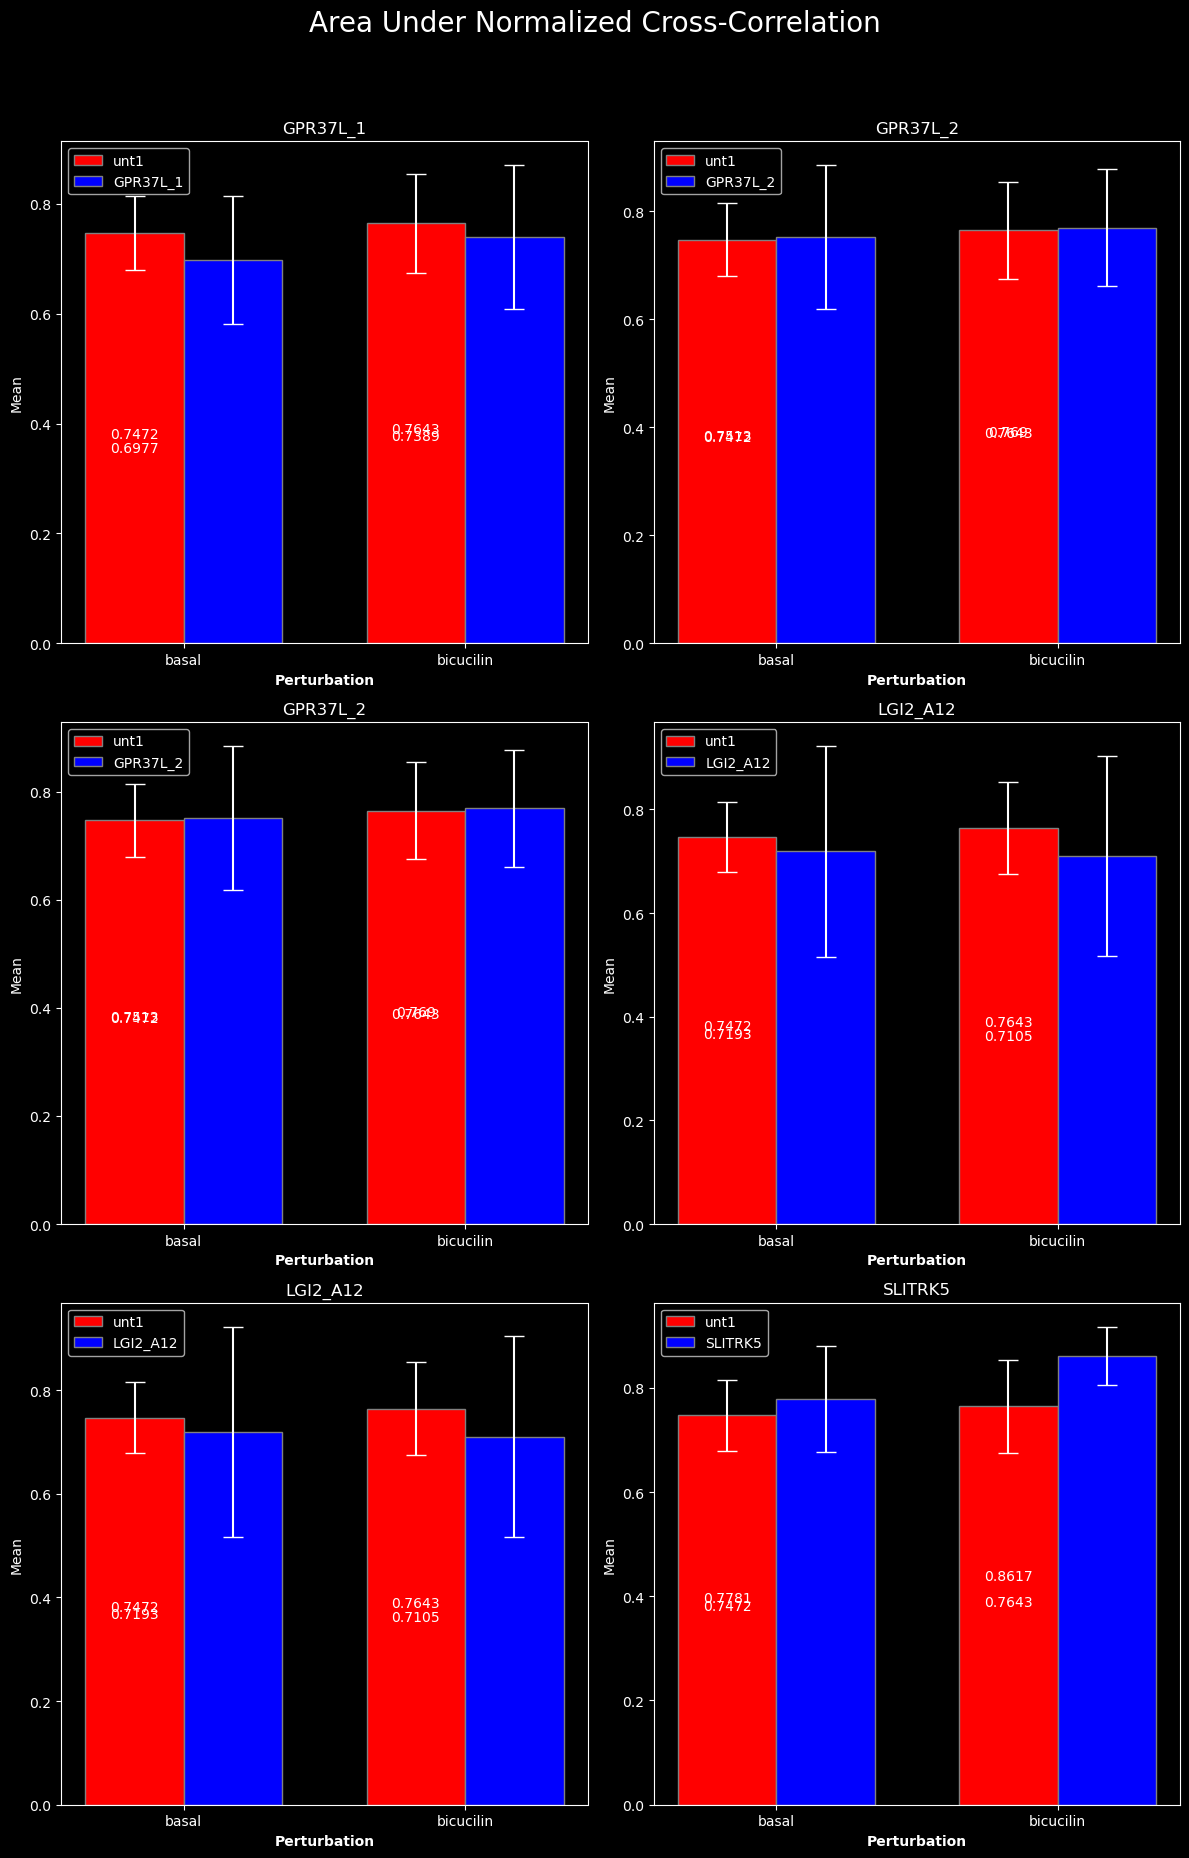

In [46]:
def calculate_ANOVA(testparameter, df):
    cols=2
    rows=int(np.ceil((len(df.columns)-3)/cols)) # 3 cols not mutation genes
    bar_width=0.35
    fig, axs = plt.subplots(rows, cols, figsize=(12,6*rows))
    fig.suptitle(testparameter, fontsize=20, y=1.03)
    for ri in range(rows):
        for ci in range(cols):
            ax = axs[ri, ci]
            mut_gene = rp.summary_cont(df.iloc[:, ri+ci].groupby(df['Chemical_Type']))
            unt1 = rp.summary_cont(df['unt1'].groupby(df['Chemical_Type']))
            categories=mut_gene.index
            r1 = range(len(mut_gene['Mean']))
            r2 = [x + bar_width for x in r1]
            ax.bar(r1, unt1['Mean'], color='red', yerr=unt1['SD'],
                   capsize=7, width=bar_width, edgecolor='grey', ecolor='white', label='unt1')
            ax.bar(r2, mut_gene['Mean'], color='blue', yerr=mut_gene['SD'], 
                   capsize=7, width=bar_width, edgecolor='grey', ecolor='white', label=df.columns[ri+ci])
            addlabels(r1, unt1['Mean'], ax)
            addlabels(r2, mut_gene['Mean'], ax)
            ax.set_xlabel('Perturbation', fontweight='bold')
            ax.set_xticks([r + bar_width/2 for r in range(len(mut_gene['Mean']))])
            ax.set_xticklabels(categories)
            ax.set_ylabel('Mean')
            ax.set_title(df.columns[ri+ci])
            ax.legend()
    plt.tight_layout()
    save_figfile = f"ANOVA_plots/{plate_type}_ANOVAtest/{testparameter}"
    ensure_dirs_exists(save_figfile)
    plt.savefig(save_figfile)
    plt.show()

calculate_ANOVA('Area Under Normalized Cross-Correlation', data)

In [ ]:
for test_param, table in TestParams_dict.items():
    calculate_ANOVA(test_param, table)

In [68]:
mut_summary = rp.summary_cont(data['GPR37L_1'].groupby(data['Chemical_Type']))
unt1 = rp.summary_cont(data['unt1'].groupby(data['Chemical_Type']))
unt1

,N,Mean,SD,SE,95% Conf.,Interval
Chemical_Type,,,,,,
basal,12,0.7472,0.0676,0.0195,0.7042,0.7901
bicucilin,12,0.7643,0.0897,0.0259,0.7073,0.8213


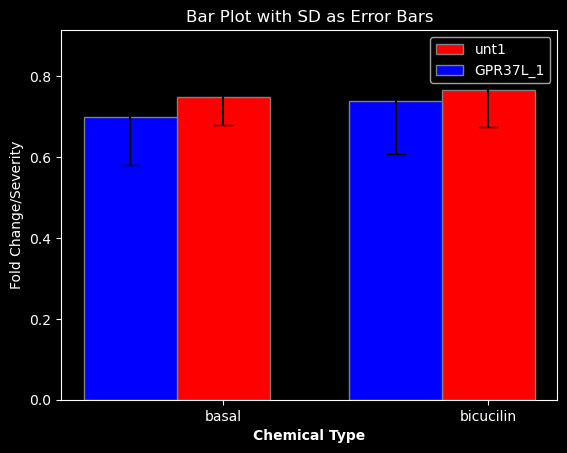

In [70]:

# Data for plotting
means_gpr = mut_summary['Mean'].tolist()
error_gpr = mut_summary['SD']
means_unt1 = unt1['Mean'].tolist()
error_unt1 = unt1['SD']
categories=mut_summary.index
categories
# Plotting


# Plotting
bar_width = 0.35
r1 = range(len(means_gpr))
r2 = [x + bar_width for x in r1]
plt.bar(r2, means_unt1, color='red', yerr=error_unt1, capsize=7, width=bar_width, edgecolor='grey', label='unt1')

plt.bar(r1, means_gpr, color='blue', yerr=error_gpr, capsize=7, width=bar_width, edgecolor='grey', label='GPR37L_1')

# Adding labels & title
plt.xlabel('Chemical Type', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(means_gpr))], categories)
plt.ylabel('Fold Change/Severity')
plt.title('Bar Plot with SD as Error Bars')
plt.legend()
